In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [ ]:
def sin_trajectory(t):
    return torch.tensor([t, math.sin(t)])

def spiral_trajectory(t):
    return torch.tensor([t * math.cos(t), t * math.sin(t)])

In [3]:
def plot_trajectory(trajectory, estimated_trajectory, 
                    generator_function, estimation_function,
                    title):
    plt.figure(figsize=(8, 4))
    plt.plot(trajectory[:, 0].numpy(), trajectory[:, 1].numpy(), label=f'{generator_function}(t)')
    plt.plot(estimated_trajectory[:, 0].numpy(), estimated_trajectory[:, 1].numpy(), label=f'{estimation_function}(t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
PERIOD = 4
STEPS_PER_PERIOD = 100
times = torch.linspace(0, PERIOD * 2 * math.pi, steps=PERIOD*STEPS_PER_PERIOD)
trajectory = torch.stack([spiral_trajectory(t.item()) for t in times])
trajectory = trajectory.flip(0)

In [5]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim + 1] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)

		for m in self.mlp.modules():
			if isinstance(m, nn.Linear):
				nn.init.normal_(m.weight, mean=0, std=0.1)
				nn.init.constant_(m.bias, val=0)
	
	def forward(self, t, x):
		state = torch.cat([t.unsqueeze(0), x], dim=0)
		x_dot = self.mlp(state)
		return x_dot

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
ode = ODE(2, (256 for _ in range(3))).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-3, weight_decay=0)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = torch.mean(torch.abs(trajectory - estimated_trajectory))#F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    #scheduler.step()

Epoch 1, Loss: 4.004246234893799
Epoch 2, Loss: 2.9504919052124023
Epoch 3, Loss: 2.0717580318450928
Epoch 4, Loss: 2.0521178245544434
Epoch 5, Loss: 1.9068739414215088
Epoch 6, Loss: 1.7458202838897705
Epoch 7, Loss: 1.693442940711975
Epoch 8, Loss: 1.6480671167373657
Epoch 9, Loss: 1.5926384925842285
Epoch 10, Loss: 1.5285449028015137
Epoch 11, Loss: 1.467842698097229
Epoch 12, Loss: 1.4208205938339233
Epoch 13, Loss: 1.3799705505371094
Epoch 14, Loss: 1.3174206018447876
Epoch 15, Loss: 1.2220677137374878
Epoch 16, Loss: 1.1097677946090698
Epoch 17, Loss: 0.9749239087104797
Epoch 18, Loss: 0.8454858064651489
Epoch 19, Loss: 0.7490498423576355
Epoch 20, Loss: 0.7166887521743774
Epoch 21, Loss: 0.6730713248252869
Epoch 22, Loss: 0.6376801133155823
Epoch 23, Loss: 0.6285972595214844
Epoch 24, Loss: 0.6093634366989136
Epoch 25, Loss: 0.5862045288085938
Epoch 26, Loss: 0.5328158140182495
Epoch 27, Loss: 0.45640456676483154
Epoch 28, Loss: 0.39414703845977783
Epoch 29, Loss: 0.368865698575

KeyboardInterrupt: 

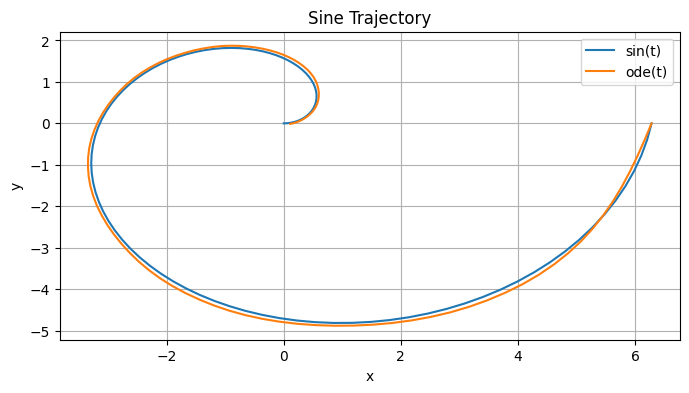

In [8]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')

In [9]:
class FourierFeatureODE(nn.Module):
    def __init__(self, input_dim, hidden_dims, fourier_scale=10.0, num_fourier_features=10):
        super(FourierFeatureODE, self).__init__()
        
        self.num_fourier_features = num_fourier_features
        
        fourier_expanded_dim = input_dim + 2 * num_fourier_features
        #dim_list = [fourier_expanded_dim + 1] + list(hidden_dims) + [input_dim]
        dim_list = [fourier_expanded_dim] + list(hidden_dims) + [input_dim]
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i < len(dim_list) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

        # for m in self.mlp.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, mean=0, std=0.1)
        #         nn.init.constant_(m.bias, val=0)
    
    def compute_positional_fourier_features(self, x):
        encodings = [x]
        for i in range(self.num_fourier_features // 2):
            freq = 2.0 ** i
            sin_features = torch.sin(freq * x)
            cos_features = torch.cos(freq * x)
            encodings.append(sin_features)
            encodings.append(cos_features)
        return torch.cat(encodings, dim=-1)

    def forward(self, t, x):
        x_fourier = self.compute_positional_fourier_features(x)
        #state = torch.cat([t.unsqueeze(0), x_fourier], dim=0)
        x_dot = self.mlp(x_fourier)
        return x_dot

In [10]:
ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=32).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-3, weight_decay=0)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

#EPOCHS = 10000
EPOCHS = 5000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = torch.mean(torch.abs(trajectory - estimated_trajectory))#F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    #scheduler.step()

Epoch 1, Loss: 4.056787490844727
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 6, Loss: nan
Epoch 7, Loss: nan
Epoch 8, Loss: nan
Epoch 9, Loss: nan
Epoch 10, Loss: nan
Epoch 11, Loss: nan
Epoch 12, Loss: nan
Epoch 13, Loss: nan
Epoch 14, Loss: nan
Epoch 15, Loss: nan
Epoch 16, Loss: nan
Epoch 17, Loss: nan
Epoch 18, Loss: nan
Epoch 19, Loss: nan
Epoch 20, Loss: nan
Epoch 21, Loss: nan
Epoch 22, Loss: nan
Epoch 23, Loss: nan


KeyboardInterrupt: 

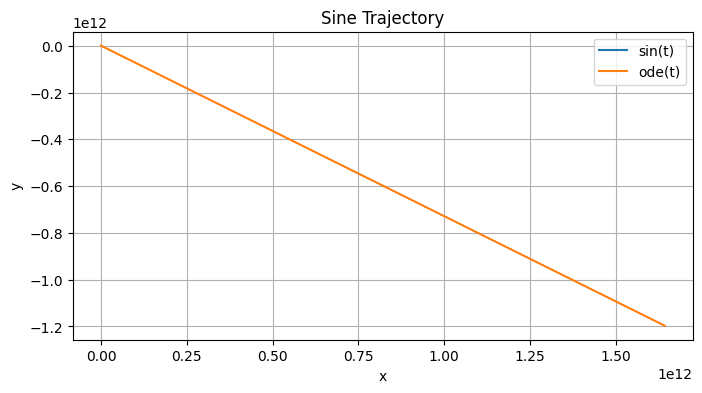

In [26]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')